In [1]:
%matplotlib inline
from IPython import display
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def use_svg_display():  #@save
    """使用svg格式在Jupyter中显示绘图"""
#     display.set_matplotlib_formats()
    plt.show()

#读取数据并且返回训练集和测试集
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="D:/书籍资料整理/torch_data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="D:/书籍资料整理/torch_data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [2]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [3]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [4]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


In [5]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [6]:
def updater(batch_size):
    return sgd([W, b], lr, batch_size)

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        exit()
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.sum().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            #反向传播
            l.sum().backward()
            #梯度下降并且更新参数
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [7]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

#计算损失函数
def cross_entropy(y_hat, y):

    a=y_hat[range(len(y_hat)), y]
    a=- torch.log(a)
    return a



def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    #animator绘制动图用的
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        #每迭代周期
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        #每迭代周期的损失函数
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [8]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

tensor([[2.6422e-01, 3.0230e-02, 2.1374e-03,  ..., 5.9009e-05, 2.7480e-03,
         1.1821e-04],
        [3.1143e-04, 7.2908e-04, 9.0272e-04,  ..., 8.2705e-01, 1.6956e-02,
         3.6644e-03],
        [5.8489e-04, 1.5994e-03, 3.0813e-01,  ..., 1.3048e-06, 2.2780e-04,
         8.5542e-06],
        ...,
        [6.7065e-03, 1.4724e-03, 3.0832e-02,  ..., 9.3288e-06, 9.7552e-04,
         4.7170e-05],
        [3.4514e-03, 6.1001e-03, 6.5518e-01,  ..., 1.2423e-04, 1.1887e-03,
         3.2322e-04],
        [4.8983e-03, 3.7946e-05, 4.0723e-03,  ..., 1.9210e-03, 9.1639e-01,
         8.8766e-04]], grad_fn=<DivBackward0>)
tensor([[1.4614e-05, 2.7094e-05, 1.4102e-04,  ..., 1.8670e-02, 2.9526e-03,
         1.1242e-01],
        [2.8910e-03, 6.0428e-04, 3.3261e-03,  ..., 2.0956e-02, 4.4980e-03,
         8.5791e-01],
        [2.1392e-03, 5.7204e-02, 1.2341e-03,  ..., 1.0152e-04, 1.0400e-04,
         3.9546e-04],
        ...,
        [2.2225e-05, 4.4619e-07, 4.2660e-04,  ..., 1.5973e-05, 9.9804e-01,
 

         5.4642e-05]], grad_fn=<DivBackward0>)
tensor([[9.3105e-01, 6.4615e-05, 2.6245e-03,  ..., 2.1142e-07, 1.1273e-04,
         2.4092e-06],
        [3.6296e-02, 8.7198e-01, 1.6950e-02,  ..., 1.2734e-03, 3.0852e-03,
         8.3459e-04],
        [1.1793e-02, 9.6073e-01, 3.1328e-03,  ..., 2.1797e-05, 1.5342e-04,
         1.1635e-05],
        ...,
        [1.4204e-03, 3.8600e-05, 1.1348e-03,  ..., 3.8664e-04, 3.2761e-03,
         9.7421e-01],
        [5.2765e-01, 4.2611e-05, 1.4605e-02,  ..., 4.1120e-07, 1.0279e-02,
         9.2618e-06],
        [5.0331e-06, 1.4804e-05, 5.2870e-05,  ..., 8.5237e-01, 1.0351e-02,
         8.9362e-03]], grad_fn=<DivBackward0>)
tensor([[6.5080e-06, 4.0087e-07, 7.9163e-06,  ..., 4.2227e-03, 1.7052e-04,
         9.4533e-01],
        [6.8558e-01, 7.5154e-04, 1.8120e-03,  ..., 1.5707e-06, 3.0780e-04,
         4.3493e-05],
        [7.7772e-03, 4.0659e-03, 5.8463e-03,  ..., 3.9780e-01, 3.3629e-02,
         1.7795e-01],
        ...,
        [1.2425e-04, 9.9689e-

         9.7544e-01]], grad_fn=<DivBackward0>)
tensor([[8.5644e-06, 1.0819e-06, 9.2054e-04,  ..., 9.1884e-05, 9.9638e-01,
         2.9408e-05],
        [6.6479e-02, 1.7363e-02, 2.7885e-01,  ..., 9.6804e-04, 1.8407e-02,
         1.6994e-03],
        [2.5591e-02, 4.4098e-03, 2.0379e-03,  ..., 2.1681e-05, 3.2192e-03,
         2.9741e-05],
        ...,
        [5.4010e-04, 6.4046e-05, 5.5894e-04,  ..., 1.2266e-03, 7.3572e-04,
         9.6453e-01],
        [1.2428e-04, 9.9941e-01, 3.0393e-05,  ..., 4.0886e-07, 8.5573e-07,
         2.6102e-07],
        [1.0631e-05, 1.2100e-05, 2.4232e-05,  ..., 3.6671e-01, 1.0456e-03,
         6.0388e-01]], grad_fn=<DivBackward0>)
tensor([[1.4414e-01, 3.3715e-02, 4.6389e-02,  ..., 4.1746e-03, 6.1579e-02,
         4.7287e-03],
        [2.5592e-06, 4.5791e-07, 5.3987e-04,  ..., 5.2872e-04, 7.9576e-03,
         6.8846e-03],
        [2.5654e-05, 1.1317e-04, 1.7553e-04,  ..., 9.8952e-01, 3.0403e-03,
         1.3367e-03],
        ...,
        [7.7238e-06, 1.8577e-

         1.0898e-03]], grad_fn=<DivBackward0>)
tensor([[1.8443e-05, 5.8542e-05, 4.2079e-05,  ..., 9.9448e-01, 5.2153e-04,
         6.8743e-04],
        [2.5620e-04, 1.3420e-05, 2.8508e-04,  ..., 3.1794e-03, 9.8951e-01,
         1.8372e-03],
        [1.6042e-05, 4.1993e-05, 6.1952e-05,  ..., 9.0022e-01, 3.1976e-03,
         3.0493e-03],
        ...,
        [9.2583e-06, 3.5553e-06, 2.7140e-05,  ..., 3.4170e-01, 3.1618e-03,
         6.2982e-01],
        [1.2441e-02, 9.8086e-04, 3.0001e-01,  ..., 2.4856e-04, 3.9764e-02,
         8.0201e-04],
        [9.4135e-01, 1.6844e-04, 2.7932e-03,  ..., 4.8868e-08, 1.6847e-04,
         8.4776e-07]], grad_fn=<DivBackward0>)
tensor([[4.4588e-06, 5.1509e-07, 1.3853e-05,  ..., 4.0068e-03, 8.8855e-04,
         9.9224e-01],
        [1.2551e-01, 1.4038e-02, 6.8496e-02,  ..., 3.7791e-04, 2.0346e-03,
         9.6697e-04],
        [1.3255e-02, 8.6308e-03, 6.6778e-01,  ..., 3.5832e-04, 1.2518e-02,
         1.2976e-03],
        ...,
        [1.1887e-02, 1.8392e-

         7.9946e-01]], grad_fn=<DivBackward0>)
tensor([[1.2719e-04, 1.8341e-04, 1.7738e-03,  ..., 2.8248e-02, 1.3493e-02,
         2.1344e-01],
        [7.4972e-04, 2.4724e-04, 1.0450e-01,  ..., 6.5571e-07, 2.1421e-02,
         2.5473e-05],
        [7.0439e-01, 1.5632e-02, 2.2898e-02,  ..., 7.8529e-05, 5.7594e-04,
         3.6541e-04],
        ...,
        [3.8554e-05, 3.8507e-05, 9.2514e-04,  ..., 2.2348e-02, 1.7715e-02,
         7.4910e-02],
        [1.7729e-02, 1.3404e-02, 7.0041e-03,  ..., 2.4457e-03, 2.1170e-02,
         4.2767e-03],
        [1.8381e-03, 1.5207e-03, 1.3344e-01,  ..., 5.7675e-06, 4.4852e-03,
         1.1948e-05]], grad_fn=<DivBackward0>)
tensor([[5.2635e-02, 2.5531e-03, 6.5247e-02,  ..., 1.8948e-05, 7.5327e-05,
         8.6739e-05],
        [5.8698e-05, 9.9939e-01, 3.4629e-05,  ..., 1.0295e-06, 3.3889e-07,
         1.2439e-06],
        [7.4917e-04, 5.3318e-04, 9.4009e-01,  ..., 5.6139e-07, 5.9812e-04,
         2.4008e-05],
        ...,
        [2.4797e-02, 6.8634e-

         2.0593e-05]], grad_fn=<DivBackward0>)
tensor([[2.0221e-01, 2.0061e-02, 8.8949e-02,  ..., 3.4683e-02, 2.0815e-01,
         4.4528e-02],
        [1.9696e-03, 3.2208e-03, 4.9243e-03,  ..., 2.0061e-01, 2.6572e-02,
         1.4297e-02],
        [4.8282e-06, 1.3535e-05, 2.5854e-05,  ..., 9.7572e-01, 7.5272e-04,
         1.2761e-03],
        ...,
        [8.3651e-05, 1.0493e-05, 4.1483e-04,  ..., 1.9581e-02, 9.5249e-01,
         3.1002e-03],
        [6.1587e-03, 5.5068e-04, 3.6867e-01,  ..., 8.5090e-07, 7.7131e-03,
         2.2659e-05],
        [4.5100e-06, 7.1761e-07, 7.5817e-06,  ..., 1.4334e-02, 3.5407e-04,
         9.8098e-01]], grad_fn=<DivBackward0>)
tensor([[4.4654e-04, 6.9460e-05, 2.5700e-04,  ..., 5.7161e-02, 1.0462e-03,
         8.7690e-01],
        [3.9782e-05, 3.5639e-05, 2.0398e-04,  ..., 1.3062e-01, 3.4154e-03,
         1.3695e-02],
        [1.9939e-01, 6.7923e-03, 6.3205e-03,  ..., 1.0572e-02, 4.8083e-01,
         4.3131e-03],
        ...,
        [1.6726e-04, 1.3478e-

         2.1009e-05]], grad_fn=<DivBackward0>)
tensor([[2.1871e-03, 2.4658e-03, 3.4161e-03,  ..., 6.7138e-01, 2.2106e-02,
         1.0932e-01],
        [6.6912e-02, 8.8513e-03, 2.1097e-03,  ..., 1.6117e-05, 6.8053e-05,
         3.6751e-05],
        [5.6175e-04, 5.3703e-04, 8.0265e-01,  ..., 2.1594e-06, 3.0315e-03,
         3.7945e-05],
        ...,
        [2.7297e-01, 7.6403e-04, 1.3287e-01,  ..., 1.9364e-06, 4.2903e-02,
         1.8847e-04],
        [6.6618e-01, 3.8731e-02, 1.3454e-01,  ..., 1.5278e-03, 1.0704e-02,
         3.5930e-03],
        [5.3936e-04, 9.8642e-04, 1.1598e-03,  ..., 7.2010e-01, 9.3427e-03,
         1.1470e-01]], grad_fn=<DivBackward0>)
tensor([[2.5513e-02, 5.0755e-04, 6.1718e-01,  ..., 3.2692e-07, 1.6468e-02,
         3.9041e-05],
        [9.1101e-01, 9.7349e-05, 1.6943e-04,  ..., 3.6154e-08, 1.7250e-05,
         4.5780e-07],
        [1.2332e-01, 9.8063e-03, 2.4358e-01,  ..., 1.9196e-04, 5.9723e-02,
         1.1738e-03],
        ...,
        [2.3838e-02, 1.3259e-

         3.0136e-04]], grad_fn=<DivBackward0>)
tensor([[1.4984e-01, 4.4896e-01, 8.2112e-02,  ..., 1.4273e-02, 1.6921e-02,
         1.1615e-02],
        [2.5622e-02, 6.7886e-03, 6.6180e-01,  ..., 5.8532e-04, 6.1781e-02,
         2.4667e-03],
        [2.8985e-02, 1.5514e-02, 3.3396e-01,  ..., 1.5599e-02, 4.1549e-02,
         3.8711e-02],
        ...,
        [3.5699e-06, 2.9206e-07, 4.1092e-05,  ..., 2.0572e-03, 1.5238e-03,
         9.8308e-01],
        [4.4874e-03, 7.0826e-03, 4.4616e-02,  ..., 4.5897e-05, 3.6724e-03,
         1.5794e-04],
        [2.0413e-04, 6.9385e-05, 1.6406e-01,  ..., 4.0502e-07, 1.5326e-03,
         1.1608e-05]], grad_fn=<DivBackward0>)
tensor([[1.0178e-04, 2.1845e-04, 5.0200e-04,  ..., 3.6658e-01, 5.8068e-03,
         3.8355e-02],
        [8.6946e-03, 1.4220e-04, 2.6782e-02,  ..., 9.7421e-05, 7.7331e-01,
         2.8796e-03],
        [2.2280e-06, 3.4943e-07, 1.4679e-05,  ..., 5.2672e-02, 6.9900e-03,
         9.1968e-01],
        ...,
        [2.2243e-05, 4.8718e-

         3.5579e-01]], grad_fn=<DivBackward0>)
tensor([[1.0908e-03, 2.1949e-03, 2.6564e-03,  ..., 7.4178e-01, 1.9863e-02,
         1.4582e-01],
        [8.2658e-03, 1.3948e-03, 2.5839e-01,  ..., 2.3811e-06, 6.2020e-03,
         3.4029e-05],
        [1.7887e-04, 9.9877e-01, 8.4003e-05,  ..., 2.6283e-06, 2.9098e-06,
         2.5434e-06],
        ...,
        [3.2657e-02, 4.9620e-02, 9.7212e-03,  ..., 1.0473e-03, 6.6759e-03,
         6.3850e-04],
        [1.0087e-01, 4.3128e-03, 3.7285e-02,  ..., 3.2976e-06, 2.1922e-03,
         1.1329e-05],
        [1.6980e-01, 1.2987e-04, 9.1472e-02,  ..., 3.7275e-05, 6.9225e-01,
         3.6032e-04]], grad_fn=<DivBackward0>)
tensor([[9.0392e-01, 7.4094e-03, 2.2288e-02,  ..., 4.0359e-05, 4.0332e-04,
         1.6697e-04],
        [8.9892e-02, 7.9805e-01, 1.2626e-02,  ..., 1.2824e-03, 6.6622e-03,
         5.2064e-04],
        [6.9841e-07, 2.7285e-06, 1.2636e-05,  ..., 9.1150e-01, 3.5219e-03,
         1.3137e-03],
        ...,
        [1.5374e-02, 1.6272e-

         2.9068e-04]], grad_fn=<DivBackward0>)
tensor([[2.3766e-05, 2.2417e-05, 2.1894e-03,  ..., 4.1150e-03, 9.8115e-01,
         1.0641e-03],
        [5.0004e-06, 1.3499e-05, 1.4476e-05,  ..., 9.8129e-01, 3.1268e-04,
         7.0236e-04],
        [1.1969e-04, 9.9929e-01, 4.4493e-05,  ..., 1.8831e-06, 5.3334e-07,
         1.2001e-06],
        ...,
        [2.3035e-05, 2.7464e-06, 3.4219e-05,  ..., 3.8479e-02, 2.1713e-03,
         9.3121e-01],
        [2.5847e-03, 9.8679e-01, 7.5480e-04,  ..., 7.0824e-05, 8.9769e-05,
         1.0088e-04],
        [8.4668e-04, 7.9576e-04, 2.6857e-03,  ..., 2.2635e-01, 4.1835e-02,
         1.1789e-01]], grad_fn=<DivBackward0>)
tensor([[1.3639e-03, 9.8768e-01, 6.8820e-04,  ..., 1.1610e-05, 7.4838e-06,
         7.8782e-06],
        [2.4783e-04, 1.7426e-04, 6.1394e-04,  ..., 3.7170e-02, 6.5623e-03,
         7.9048e-03],
        [1.3389e-03, 1.9908e-03, 2.6637e-03,  ..., 8.1785e-01, 1.1650e-02,
         1.6492e-02],
        ...,
        [7.4433e-02, 5.0356e-

         5.2425e-05]], grad_fn=<DivBackward0>)
tensor([[5.2903e-03, 1.0310e-03, 3.4571e-01,  ..., 3.1494e-06, 2.4601e-03,
         7.8667e-05],
        [7.2178e-03, 2.3532e-02, 1.3028e-03,  ..., 1.9753e-04, 2.9592e-04,
         5.2400e-04],
        [1.9759e-03, 2.0510e-03, 3.0768e-01,  ..., 6.4708e-05, 2.1699e-03,
         5.7348e-04],
        ...,
        [8.1148e-05, 9.9915e-01, 7.2543e-05,  ..., 2.2894e-06, 1.2652e-06,
         3.1659e-06],
        [6.2767e-03, 1.3520e-03, 2.4929e-02,  ..., 7.9887e-02, 5.8902e-01,
         1.9219e-02],
        [5.0387e-03, 1.5860e-02, 1.8943e-03,  ..., 1.5167e-04, 1.5811e-03,
         4.6300e-04]], grad_fn=<DivBackward0>)
tensor([[1.7641e-05, 4.3591e-05, 1.5939e-04,  ..., 6.3602e-01, 1.0633e-02,
         8.2702e-03],
        [1.3492e-01, 3.7215e-02, 1.1841e-02,  ..., 1.0607e-04, 2.2075e-04,
         1.5163e-04],
        [4.4078e-05, 9.3117e-05, 7.5555e-04,  ..., 9.3933e-03, 2.9388e-03,
         9.9159e-03],
        ...,
        [1.5752e-04, 1.9199e-

KeyboardInterrupt: 

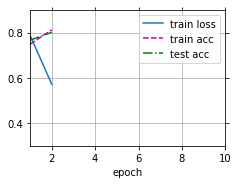

In [9]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
num_inputs = 784
num_outputs = 10
#初始化模型参数。注意
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

lr = 0.1
num_epochs = 10

#我其实习惯倒追内容来理解程序,train_ch3是核心函数,训练过程函数
#cross_entropy updater都是函数,cross_entropy计算损失函数
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)
predict_ch3(net, test_iter)